In [64]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [65]:
# Load the dataset
df = pd.read_csv("country_data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [66]:
df.shape

(167, 10)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [68]:
df.duplicated().sum()

np.int64(0)

In [69]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

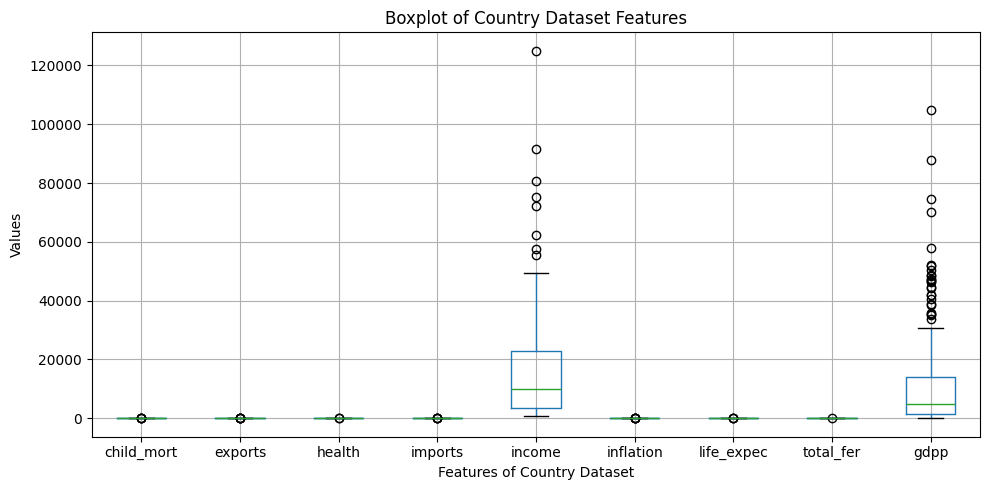

In [70]:
# Boxplot of the dataset to spot outliers
df.boxplot(figsize=(10,5))

# Add title and labels
plt.title('Boxplot of Country Dataset Features')
plt.xlabel('Features of Country Dataset')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

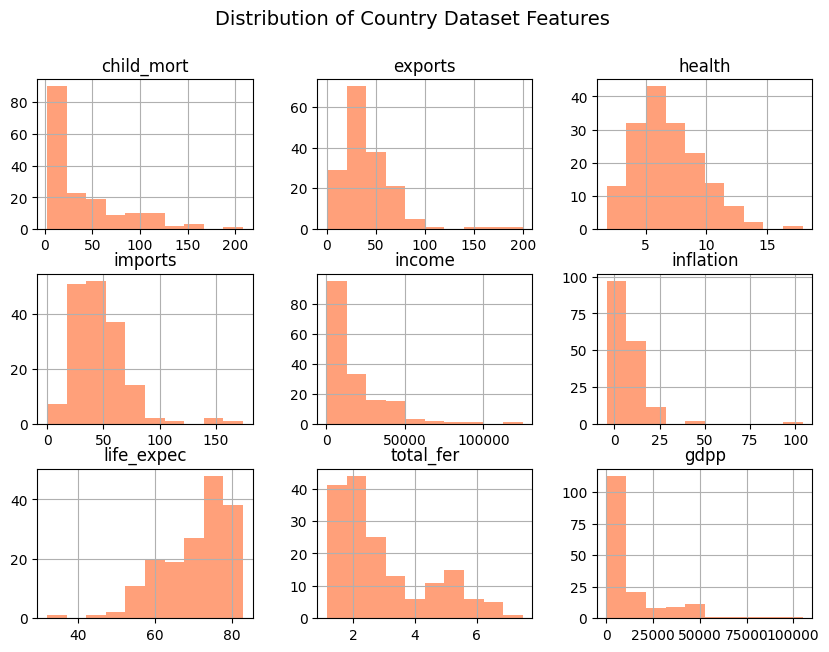

In [71]:
# Histogram of the dataset
df.hist(bins=10, color='#FFA07A', figsize=(10,7))

# Add title
plt.suptitle('Distribution of Country Dataset Features', fontsize=14)

plt.show()

In [72]:
# Feature Clipping 'gdpp'
# Define lower and upper limits based on percentiles
lower_limit, upper_limit = np.percentile(df['gdpp'], [1,99])

# Clip the 'gdpp' values
df['gdpp'] = np.clip(df['gdpp'], lower_limit, upper_limit)

In [73]:
# Feature Clipping 'income'
# Define lower and upper limits based on percentiles
lower_limit, upper_limit = np.percentile(df['income'], [1,99])

# Clip the 'gdpp' values
df['income'] = np.clip(df['income'], lower_limit, upper_limit)

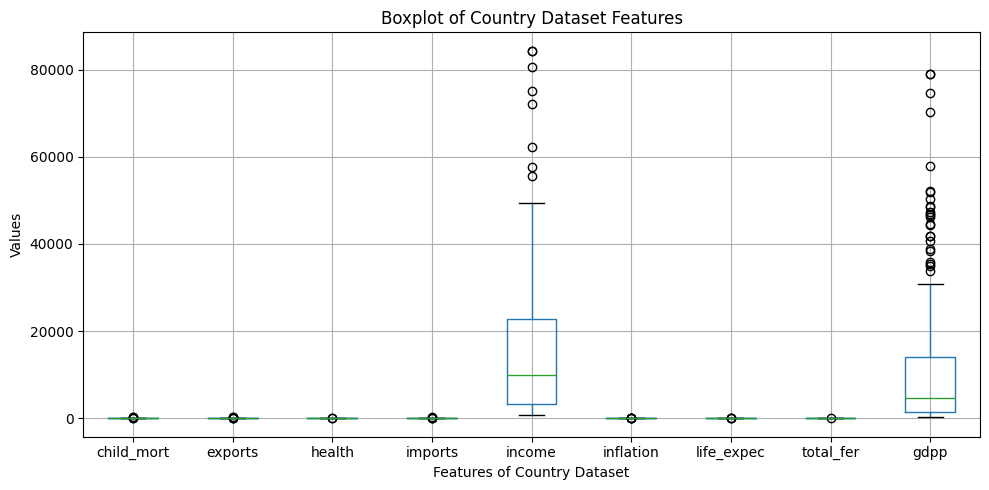

In [74]:
# Boxplot of the dataset to spot outliers
df.boxplot(figsize=(10,5))

# Add title and labels
plt.title('Boxplot of Country Dataset Features')
plt.xlabel('Features of Country Dataset')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

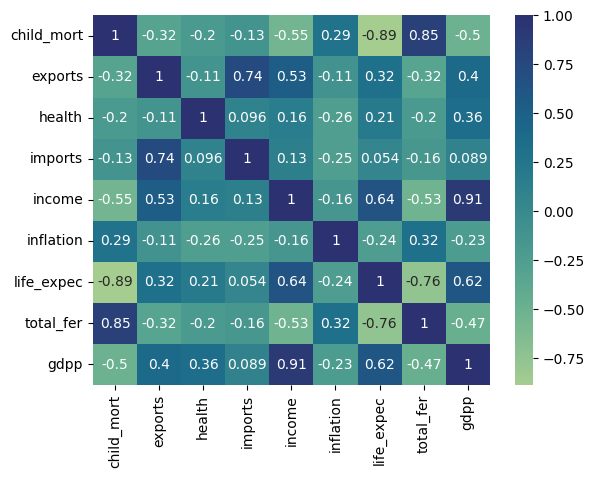

In [75]:
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='crest')
plt.show()

In [76]:
# Scale the features
features = df[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [77]:
# Finding the k value
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(scaled_features)
    sse.append(km.inertia_)

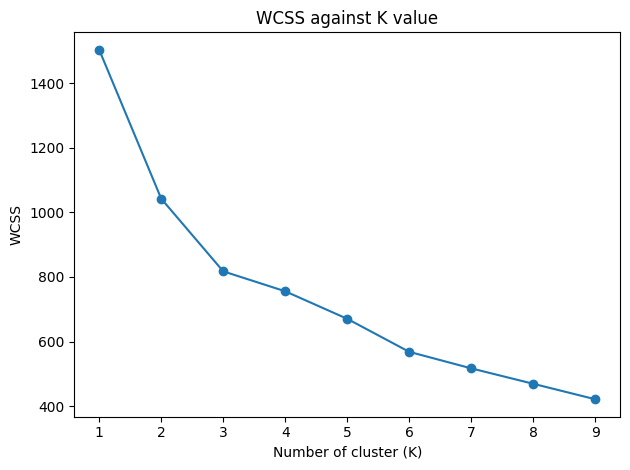

In [78]:
# plot
plt.plot(k_rng, sse, marker='o')
plt.xlabel('Number of cluster (K)')
plt.ylabel('WCSS')
plt.title('WCSS against K value')
plt.tight_layout()
plt.show()

In [79]:
## dimensionality reduction
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(scaled_features)

In [80]:
# Use the cluster to be 3
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(reduced_data)
y_predicted

array([1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1,
       2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0,
       0, 2, 2, 2, 2, 1, 1, 0, 2, 0, 2, 1, 1, 2, 0, 1, 2, 2, 2, 1, 1, 2,
       1, 0, 0, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 2, 0, 0, 2, 1, 1, 0, 2, 1, 0, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1,
       0, 2, 1, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 0,
       1, 0, 0, 0, 1, 1, 0, 2, 2, 2, 1, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 1], dtype=int32)

In [81]:
# put the cluster into the dataframe
df['Cluster'] = y_predicted

df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,1
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,2
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,2
3,Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530.0,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200.0,2
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950.0,2.62,63.0,3.50,2970.0,1
163,Venezuela,17.1,28.5,4.91,17.6,16500.0,45.90,75.4,2.47,13500.0,2
164,Vietnam,23.3,72.0,6.84,80.2,4490.0,12.10,73.1,1.95,1310.0,2
165,Yemen,56.3,30.0,5.18,34.4,4480.0,23.60,67.5,4.67,1310.0,1


In [82]:
# centroid
km.cluster_centers_

array([[ 2.74422773,  0.66882443,  0.22879886],
       [-2.26271265,  0.32090804, -0.09762851],
       [ 0.45792385, -0.48815405, -0.02439994]])

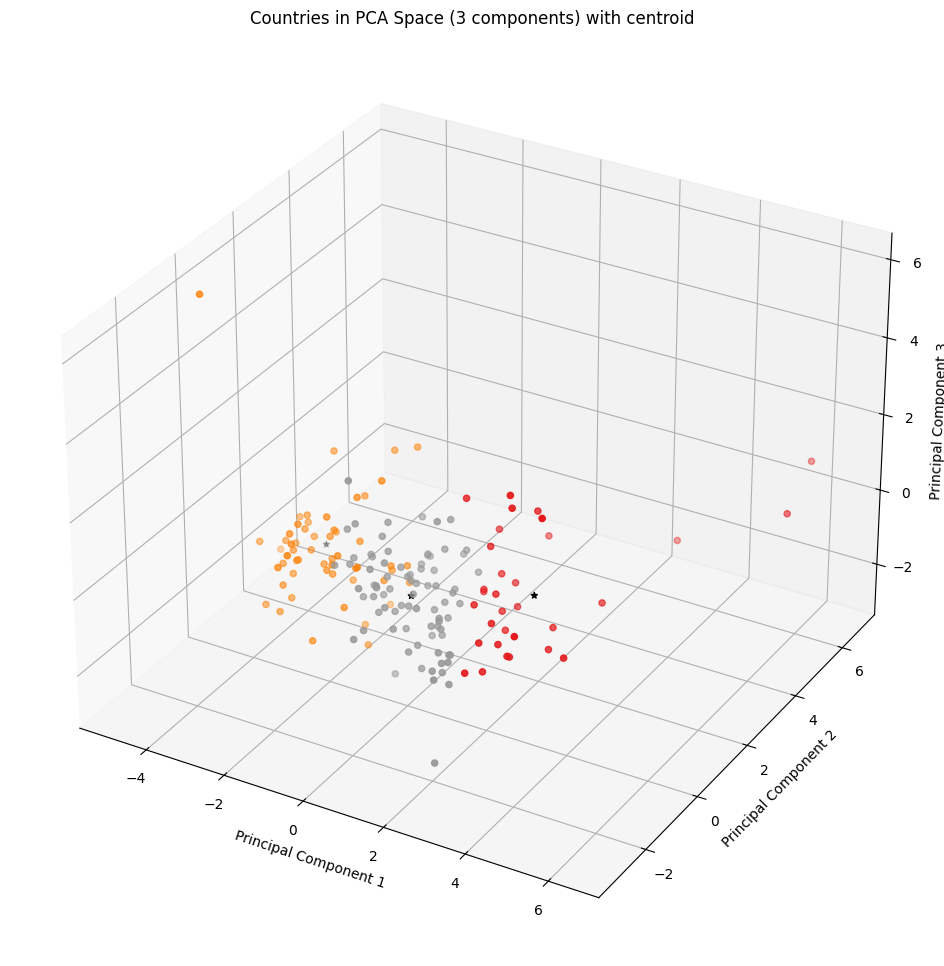

In [87]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot in 3D
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df["Cluster"], cmap="Set1")
scatter = ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color = 'black', marker='*', label = 'centroid')

# Add title and labels
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.title("Countries in PCA Space (3 components) with centroid")

plt.show()

In [ ]:
# Statistics summary per cluster
numeric_cols = df.select_dtypes(include="number").columns
cluster_summary = df.groupby("Cluster")[numeric_cols].agg(["mean", "median", "min", "max"])
print(cluster_summary)

        child_mort                        exports                        \
              mean median   min    max       mean median     min    max   
Cluster                                                                   
0         6.225000    4.5   2.6   19.7  74.468750  66.35  29.100  200.0   
1        85.810909   81.0  26.1  208.0  29.345436  23.80   0.109   85.8   
2        18.403750   16.6   3.2   62.0  35.852500  32.65  10.700   77.6   

           health         ... total_fer                gdpp                    \
             mean median  ...       min   max          mean   median      min   
Cluster                   ...                                                   
0        7.511875   7.99  ...      1.15  2.90  36800.812500  36900.0  8080.00   
1        6.226000   5.44  ...      2.41  7.49   1851.295273    967.0   331.62   
2        6.942625   6.51  ...      1.27  4.34  10638.100000   5935.0   758.00   

                 Cluster                 
             max    

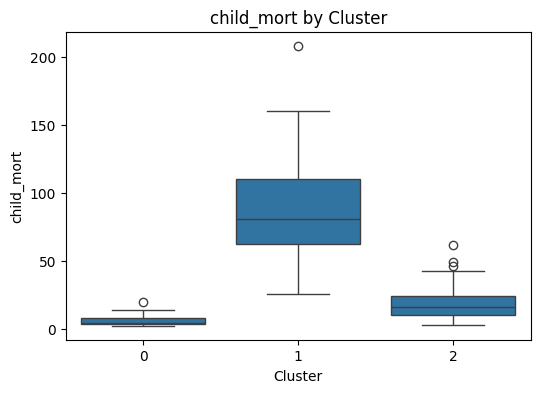

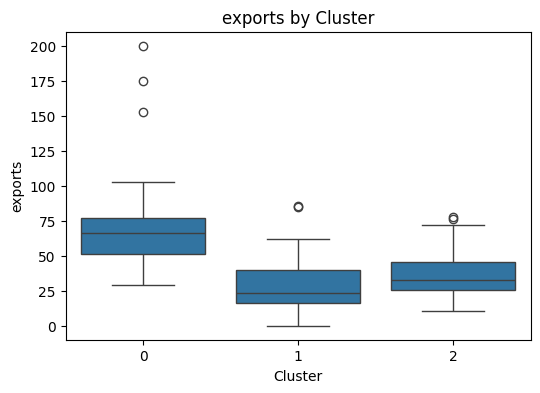

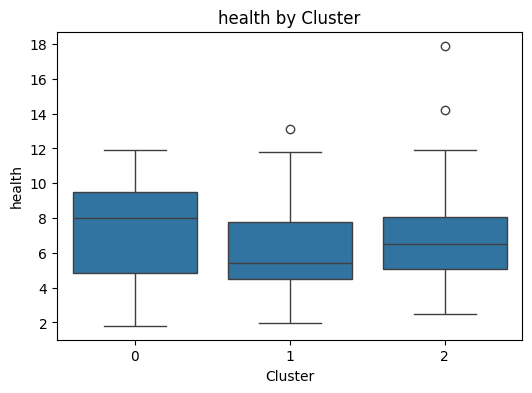

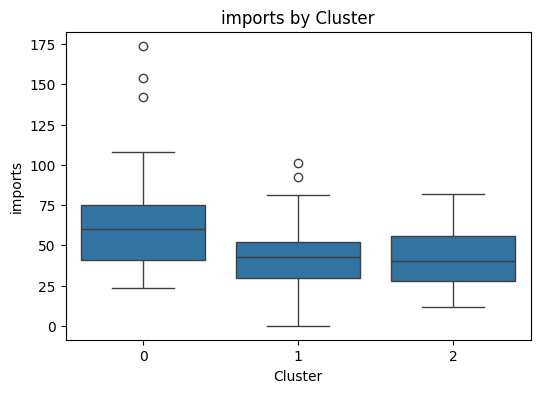

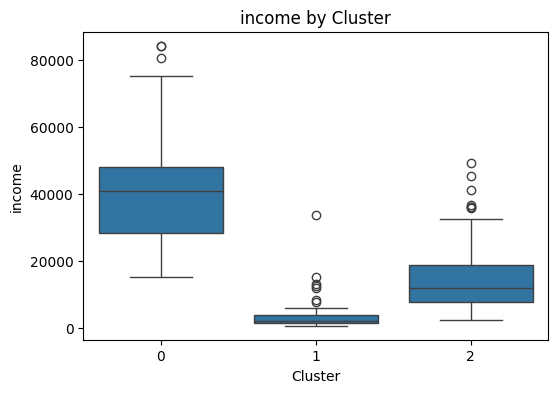

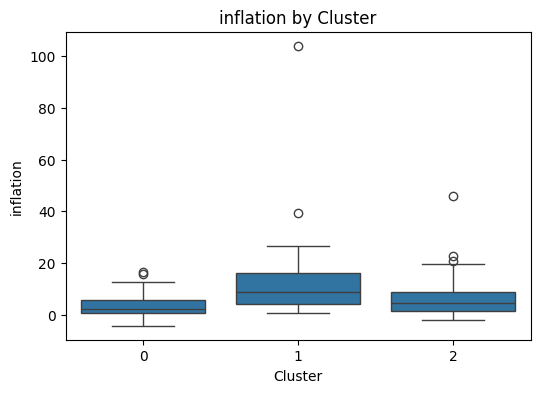

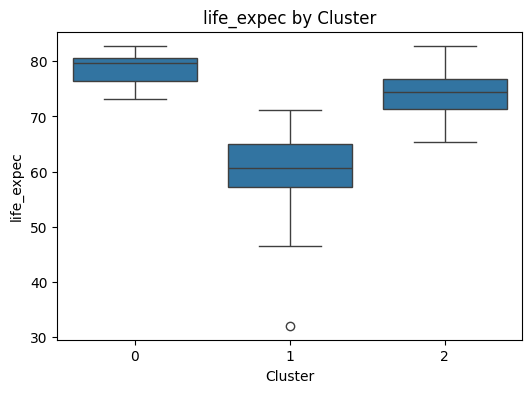

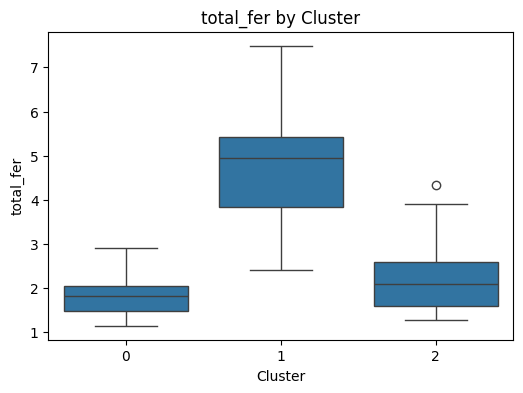

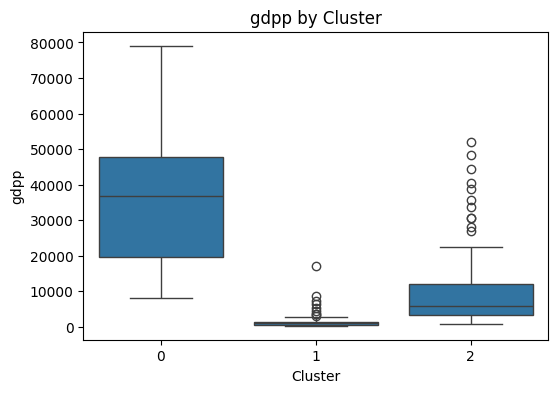

In [92]:
# Check the distribution of each Feature by cluster
features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
for feat in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Cluster", y=feat, data=df)
    plt.title(f"{feat} by Cluster")
    plt.show()